In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from numpy.typing import NDArray


In [3]:
# 価格を生成する関数
def create_price(r_min: float, r_max: float, M: int) -> NDArray[np.float_]:
    # r_minとr_maxの間のランダムな0.1刻みの少数をM個生成
    price = np.random.uniform(r_min, r_max, M)
    price = np.round(price, 1)

    return price


# alphaを作成する関数
def alpha_star(M: int) -> NDArray[np.float_]:
    alpha_star = np.random.uniform(M, 3 * M, size=M)
    return alpha_star


# betaを作成する関数
def beta_star(M: int, M_prime: int) -> NDArray[np.float_]:
    beta_star = np.zeros((M, M_prime))

    for m in range(M):
        for m_prime in range(M_prime):
            if m == m_prime:
                beta_star[m, m_prime] = np.random.uniform(-2 * M, -M)
            else:
                beta_star[m, m_prime] = np.random.uniform(0, 1)

    return beta_star


def quantity_function(
    price: NDArray[np.float_], alpha: NDArray[np.float_], beta: NDArray[np.float_]
) -> list[float]:
    M = len(price)
    quantity_list = []

    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]

        quantity = alpha[m] + sum_beta
        quantity_list.append(quantity)

    return quantity_list


def sales_function(
    price: NDArray[np.float_], alpha: NDArray[np.float_], beta: NDArray[np.float_]
) -> list[float]:
    M = len(price)
    sales = 0

    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]

        quantity = alpha[m] + sum_beta
        sales += quantity * price[m]

    return -sales


In [4]:
def objective_function(
    price: NDArray[np.float_], coefs: NDArray[np.float_], intercept: NDArray[np.float_]
) -> float:
    M = len(price)
    sales = 0

    for m in range(M):
        quantity = 0
        for m_prime in range(M):
            quantity += coefs[m][m_prime] * price[m_prime]

        sales += (intercept[m] + quantity) * price[m]

    return -sales


In [5]:
# このデータにおけるalpha,betaを作成
M = 20
alpha = alpha_star(M)
beta = beta_star(M, M)
r_m = 0.6
r_M = 1.0
# 価格を入れるリスト
price_list = []
# 売上を入れるリスト
quantity_list = []

# 価格と対応する売上を10000件生成
for i in range(500):
    price = create_price(r_m, r_M, M)
    price_list.append(price)
    quantity = quantity_function(price, alpha, beta)
    quantity_list.append(quantity)

X = np.array(price_list).astype(float)
y = np.array(quantity_list).astype(float)


In [6]:
initial_prices = np.full(M, r_m)

In [7]:
lr = MultiOutputRegressor(LinearRegression())
lr.fit(X, y)
coefs = [lr.estimators_[m].coef_ for m in range(M)]
intercept = [lr.estimators_[m].intercept_ for m in range(M)]

# Nelder-Mead法を用いて最適化
result = minimize(
    objective_function,
    initial_prices,
    args=(coefs, intercept),
    method="Nelder-Mead",
    bounds=[(r_m, r_M)] * M,
    options={"adaptive": True},
)

# 最適化された価格
optimal_prices_pred = result.x

print("Optimal Prices:", optimal_prices_pred)

optimal_sales_pred = -result.fun
print("Optimal Sales:", optimal_sales_pred)


Optimal Prices: [1.         0.69851491 0.76401361 1.         1.         0.7743455
 0.99891373 1.         1.         0.99693726 0.67994121 1.
 0.88597983 0.81703418 1.         0.6        0.99983236 0.80372289
 0.99987076 0.92101926]
Optimal Sales: 479.95567359948984


In [8]:
# Nerdar-Mead法を用いてsales_functionを最適化
result = minimize(
    sales_function,
    initial_prices,
    args=(alpha, beta),
    method="Nelder-Mead",
    bounds=[(r_m, r_M)] * M,
    options={"adaptive": True},
)

optimal_prices = result.x

print("Optimal Prices:", optimal_prices)

optimal_sales = -result.fun
print("Optimal Sales:", optimal_sales)


Optimal Prices: [1.         0.69851491 0.76401361 1.         1.         0.7743455
 0.99891373 1.         1.         0.99693726 0.67994121 1.
 0.88597983 0.81703418 1.         0.6        0.99983236 0.80372289
 0.99987076 0.92101926]
Optimal Sales: 479.95567359949024


In [9]:
dash_sales = -sales_function(optimal_prices_pred, alpha, beta)
print("Dash Sales:", dash_sales)


Dash Sales: 479.95567359949024


In [10]:
# cross validationを実装
kf = KFold(n_splits=5, shuffle=True, random_state=0)

cv_sales_list = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lr = MultiOutputRegressor(LinearRegression())
    lr.fit(X_train, y_train)
    coefs_tilda = [lr.estimators_[m].coef_ for m in range(M)]
    intercept_tilda = [lr.estimators_[m].intercept_ for m in range(M)]

    result = minimize(
        objective_function,
        initial_prices,
        args=(coefs_tilda, intercept_tilda),
        method="Nelder-Mead",
        bounds=[(r_m, r_M)] * M,
        options={"adaptive": True},
    )

    optimal_prices_pred = result.x

    lr_hat = MultiOutputRegressor(LinearRegression())
    lr_hat.fit(X_test, y_test)
    coefs_hat = [lr_hat.estimators_[m].coef_ for m in range(M)]
    intercept_hat = [lr_hat.estimators_[m].intercept_ for m in range(M)]
    cv_sales = -objective_function(optimal_prices_pred, coefs_hat, intercept_hat)

    cv_sales_list.append(cv_sales)

cv_sales = np.mean(cv_sales_list)


In [11]:
print("CV Sales:", cv_sales)

CV Sales: 479.9556735994902


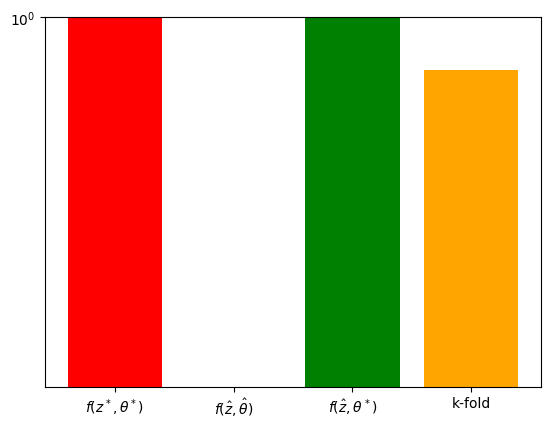

In [13]:
plt.bar(
    [
        r"$f(z^*,\theta^*)$",
        r"$f(\hat{z},\hat\theta)$",
        r"$f(\hat{z},\theta^*)$",
        r"k-fold",
    ],
    [
        optimal_sales / optimal_sales,
        optimal_sales_pred / optimal_sales,
        dash_sales / optimal_sales,
        cv_sales / optimal_sales,
    ],
    color=["red", "blue", "green", "orange"],
)
plt.yscale("log")

plt.show()


In [14]:
def create_date(M: int):
    alpha = alpha_star(M)
    beta = beta_star(M, M)
    r_m = 0.6
    r_M = 1.0
    price_list = []
    quantity_list = []

    # 価格と対応する売上を500件生成
    for i in range(500):
        price = create_price(r_m, r_M, M)
        price_list.append(price)
        quantity = quantity_function(price, alpha, beta)
        quantity_list.append(quantity)

    X = np.array(price_list).astype(float)
    y = np.array(quantity_list).astype(float)

    return alpha, beta, X, y


In [15]:
def pred_neldar(M, X, y, initial_prices):
    lr = MultiOutputRegressor(LinearRegression())
    lr.fit(X, y)

    coefs = [lr.estimators_[m].coef_ for m in range(M)]
    intercept = [lr.estimators_[m].intercept_ for m in range(M)]

    # Nelder-Mead法を用いて最適化
    result = minimize(
        objective_function,
        initial_prices,
        args=(coefs, intercept),
        method="Nelder-Mead",
        bounds=[(0.6, 1.0)] * M,  # assuming r_m = 0.6 and r_M = 1.0
        options={"adaptive": True},
    )

    # 最適化された価格
    optimal_prices_pred = result.x
    optimal_sales_pred = -result.fun

    return optimal_prices_pred, optimal_sales_pred


In [16]:
def sfuc_neldar(M, alpha, beta, initial_prices):
    # Nerdar-Mead法を用いてsales_functionを最適化
    result = minimize(
        sales_function,
        initial_prices,
        args=(alpha, beta),
        method="Nelder-Mead",
        bounds=[(0.6, 1.0)] * M,  # assuming r_m = 0.6 and r_M = 1.0
        options={"adaptive": True},
    )

    optimal_prices = result.x
    optimal_sales = -result.fun

    return optimal_prices, optimal_sales


In [17]:
def cv_neldar(M, initial_prices, X, y):
    # Cross-validation setup
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    cv_sales_list = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        lr = MultiOutputRegressor(LinearRegression())
        lr.fit(X_train, y_train)
        coefs_tilda = [lr.estimators_[m].coef_ for m in range(M)]
        intercept_tilda = [lr.estimators_[m].intercept_ for m in range(M)]

        # Optimization using Nelder-Mead
        result = minimize(
            objective_function,
            initial_prices,
            args=(coefs_tilda, intercept_tilda),
            method="Nelder-Mead",
            bounds=[(0.6, 1.0)] * M,  # assuming r_m = 0.6 and r_M = 1.0
            options={"adaptive": True},
        )

        optimal_prices_pred = result.x

        # Validation step
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)
        coefs_hat = [lr_hat.estimators_[m].coef_ for m in range(M)]
        intercept_hat = [lr_hat.estimators_[m].intercept_ for m in range(M)]

        # Calculate sales using the test set's estimated coefficients
        cv_sales = -objective_function(optimal_prices_pred, coefs_hat, intercept_hat)
        cv_sales_list.append(cv_sales)

    # Return the average sales across cross-validation folds
    cv_sales = np.mean(cv_sales_list)

    return cv_sales


In [18]:
alpha, beta, X, y = create_date(20)
initial_prices = np.full(20, 0.6)
optimal_prices_pred, optimal_sales_pred = pred_neldar(20, X, y, initial_prices)
optimal_prices, optimal_sales = sfuc_neldar(20, alpha, beta, initial_prices)
dash_sales = -sales_function(optimal_prices_pred, alpha, beta)
cv_sales = cv_neldar(20, initial_prices, X, y)
print("Optimal Prices (Prediction):", optimal_sales_pred)
print("Optimal Sales (Prediction):", optimal_sales)
print("Dash Sales:", dash_sales)
print("CV Sales:", cv_sales)


Optimal Prices (Prediction): 457.9853536659798
Optimal Sales (Prediction): 457.98535366598014
Dash Sales: 457.98535366598014
CV Sales: 457.98535366598014


In [19]:
# 上の流れを1000回繰り返してそれぞれの結果をlistに格納
optimal_sales_pred_list = []
optimal_sales_list = []
dash_sales_list = []
cv_sales_list = []

for i in range(100):
    alpha, beta, X, y = create_date(20)
    initial_prices = np.full(20, 0.6)
    optimal_prices_pred, optimal_sales_pred = pred_neldar(20, X, y, initial_prices)
    optimal_prices, optimal_sales = sfuc_neldar(20, alpha, beta, initial_prices)
    dash_sales = -sales_function(optimal_prices_pred, alpha, beta)
    cv_sales = cv_neldar(20, initial_prices, X, y)

    optimal_sales_pred_list.append(optimal_sales_pred)
    optimal_sales_list.append(optimal_sales)
    dash_sales_list.append(dash_sales)
    cv_sales_list.append(cv_sales)


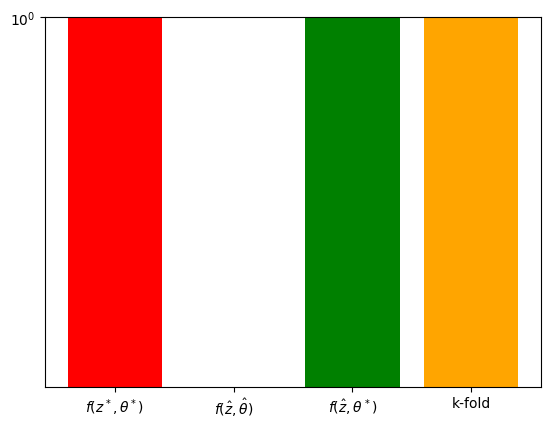

In [20]:
# optimal_sales_pred_list, optimal_sales_list, dash_sales_list, cv_sales_listの平均を出す
optimal_sales_pred_mean = np.mean(optimal_sales_pred_list)
optimal_sales_mean = np.mean(optimal_sales_list)
dash_sales_mean = np.mean(dash_sales_list)
cv_sales_mean = np.mean(cv_sales_list)

plt.bar(
    [
        r"$f(z^*,\theta^*)$",
        r"$f(\hat{z},\hat\theta)$",
        r"$f(\hat{z},\theta^*)$",
        r"k-fold",
    ],
    [
        optimal_sales_mean / optimal_sales_mean,
        optimal_sales_pred_mean / optimal_sales_mean,
        dash_sales_mean / optimal_sales_mean,
        cv_sales_mean / optimal_sales_mean,
    ],
    color=["red", "blue", "green", "orange"],
)
plt.yscale("log")

plt.show()


In [21]:
def quantity_function_norm(
    price: NDArray[np.float_], alpha: NDArray[np.float_], beta: NDArray[np.float_]
) -> list[float]:
    M = len(price)
    quantity_list = []

    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]

        quantity = alpha[m] + sum_beta + 1 * np.random.normal(0, 5)
        quantity_list.append(quantity)
    print("quantity_list", quantity_list)

    return quantity_list


def create_date_norm(M: int):
    alpha = alpha_star(M)
    beta = beta_star(M, M)
    r_m = 0.6
    r_M = 1.0
    price_list = []
    quantity_list = []

    # 価格と対応する売上を500件生成
    for i in range(500):
        price = create_price(r_m, r_M, M)
        price_list.append(price)
        quantity = quantity_function_norm(price, alpha, beta)
        quantity_list.append(quantity)

    X = np.array(price_list).astype(float)
    y = np.array(quantity_list).astype(float)

    return alpha, beta, X, y


In [22]:
# 上の流れを1000回繰り返してそれぞれの結果をlistに格納
optimal_sales_pred_list_norm = []
optimal_sales_list_norm = []
dash_sales_list_norm = []
cv_sales_list_norm = []

for i in range(100):
    alpha, beta, X, y = create_date(20)
    initial_prices = np.full(20, 0.6)
    optimal_prices_pred, optimal_sales_pred = pred_neldar(20, X, y, initial_prices)
    optimal_prices, optimal_sales = sfuc_neldar(20, alpha, beta, initial_prices)
    dash_sales = -sales_function(optimal_prices_pred, alpha, beta)
    cv_sales = cv_neldar(20, initial_prices, X, y)

    optimal_sales_pred_list_norm.append(optimal_sales_pred)
    optimal_sales_list_norm.append(optimal_sales)
    dash_sales_list_norm.append(dash_sales)
    cv_sales_list_norm.append(cv_sales)


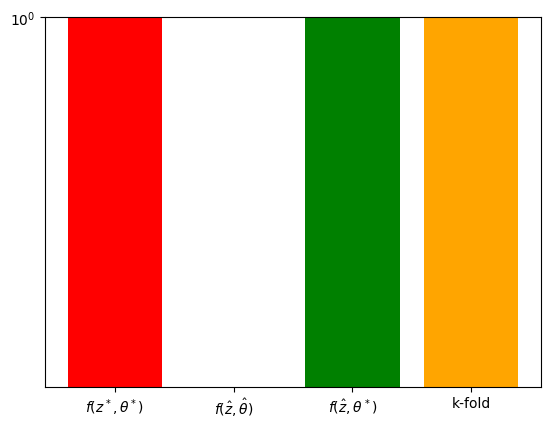

In [23]:
# optimal_sales_pred_list, optimal_sales_list, dash_sales_list, cv_sales_listの平均を出す
optimal_sales_pred_mean_norm = np.mean(optimal_sales_pred_list_norm)
optimal_sales_mean_norm = np.mean(optimal_sales_list_norm)
dash_sales_mean_norm = np.mean(dash_sales_list_norm)
cv_sales_mean_norm = np.mean(cv_sales_list_norm)

plt.bar(
    [
        r"$f(z^*,\theta^*)$",
        r"$f(\hat{z},\hat\theta)$",
        r"$f(\hat{z},\theta^*)$",
        r"k-fold",
    ],
    [
        optimal_sales_mean_norm / optimal_sales_mean_norm,
        optimal_sales_pred_mean_norm / optimal_sales_mean_norm,
        dash_sales_mean_norm / optimal_sales_mean_norm,
        cv_sales_mean_norm / optimal_sales_mean_norm,
    ],
    color=["red", "blue", "green", "orange"],
)
plt.yscale("log")

plt.show()
